# importing necessary modules

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import keras_nlp
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

# checking the version

In [ ]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)


TensorFlow: 2.18.0
Keras: 3.8.0
KerasNLP: 0.18.1


# creating the config class
holds the hyper parameters

In [ ]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en"  # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 3  # Training epochs
    batch_size = 16  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v: k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

In [ ]:
# ensures reproducibility
keras.utils.set_random_seed(CFG.seed)

Mixed precision training is the use of lower-precision operations (float16 and bfloat16) in a model during training to make it run faster and use less memory. Using mixed precision can improve performance by more than 3 times on modern GPUs and 60% on TPUs.



In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")


# Load and Preprocess Train Data

In [ ]:
BASE_PATH = '/content/drive/MyDrive/ML Projects/LLM response Classification Finetuning/Data'

In [ ]:
# Load Train Data
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df.head()


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [ ]:
# Load Test Data
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')

# Take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Show Sample
test_df.head()

,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [ ]:
# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(CFG.name2label)

# Show Sample
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,winner_model_b,1


# Define Function to Combine Prompt + Response

In our approach, we will contextualize each response with the prompt instead of using a single prompt for all responses. This means that for each response, we will provide the model with the same set of prompts combined with their respective response (e.g., `(P + R_A)`, `(P + R_B)`, etc.). This approach is similar to the multiple-choice question task in NLP.

> Note that some prompts and responses may not be encoded with `utf-8`, resulting in errors when creating the dataloader. In such cases, we will replace them with an empty string.



In [ ]:
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True

    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",
                      f"Prompt: {prompt}\n\nResponse: {response_b}"]
    return row


# apply make_pairs to the data

In [ ]:
df = df.apply(make_pairs, axis=1)
df.head()
test_df = test_df.apply(make_pairs, axis=1)
display(test_df.head(2))


,id,prompt,response_a,response_b,encode_fail,options
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...,False,"[Prompt: I have three oranges today, I ate an ..."
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...,False,[Prompt: You are a mediator in a heated politi...


## Encoding Fail Statistics

Let's examine how many samples have encoding issues. From the code below, we can see that only $1\%$ of the samples failed to be encoded, while $99\%$ of the samples don't have any issues. A similar pattern can be expected for the test data as well. Thus, considering empty strings for this small portion of the data will not have much impact on our training and inference.

In [ ]:
df.encode_fail.value_counts()

,count
encode_fail,
False,56885
True,592


## EDA
# model distribution
Calculates frequency counts of each model used to generate responses.

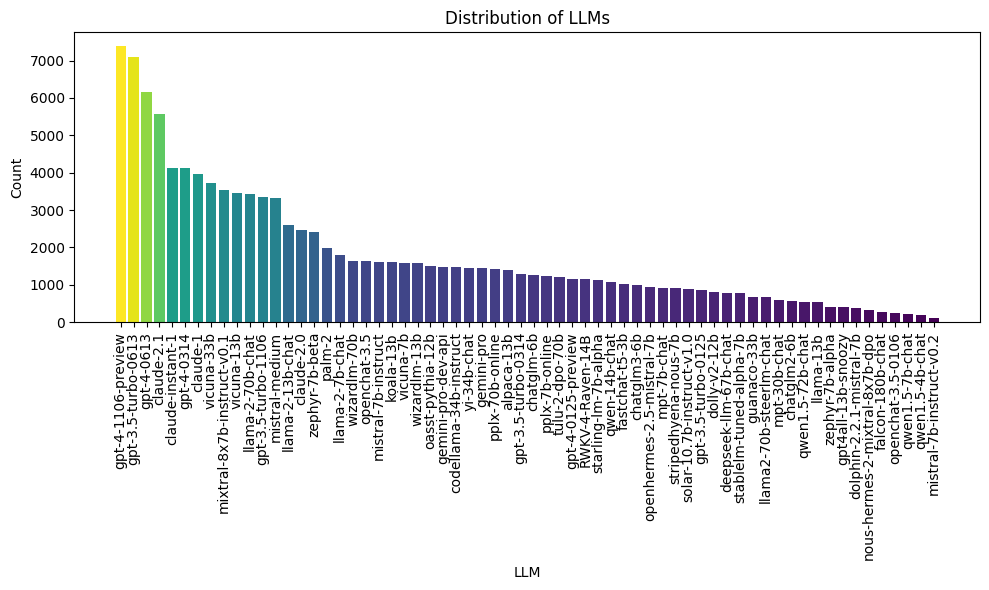

In [ ]:
model_df = pd.concat([df.model_a,df.model_b])
counts = model_df.value_counts().reset_index()
counts.columns = ['model','count']
# ploting
norm = plt.Normalize(counts['count'].min(), counts['count'].max())
colors = plt.cm.viridis(norm(counts['count']))

plt.figure(figsize=(10, 6))
bars = plt.bar(counts['model'], counts['count'],color=colors)
plt.title('Distribution of LLMs')
plt.xlabel('LLM')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


# winning distribution

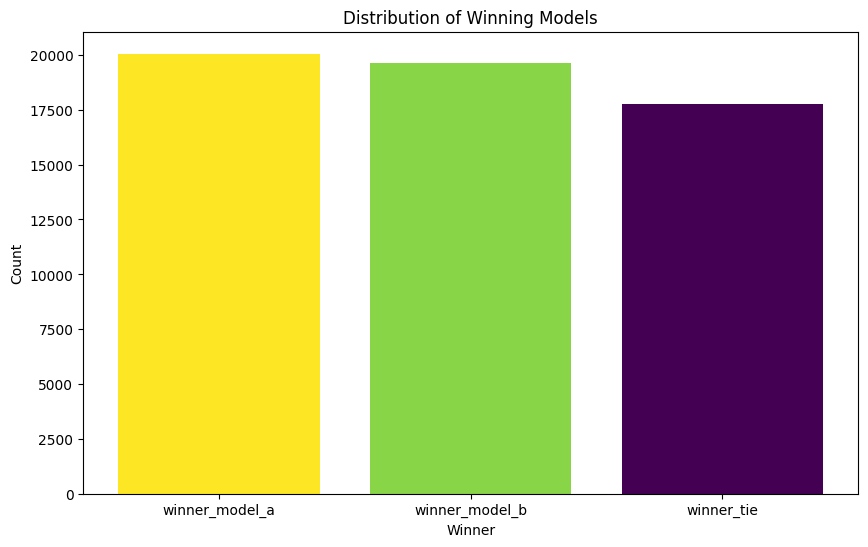

In [ ]:
counts = df['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']
# ploting
norm = plt.Normalize(counts['Win Count'].min(), counts['Win Count'].max())
colors = plt.cm.viridis(norm(counts['Win Count']))

plt.figure(figsize=(10, 6))
bars = plt.bar(counts['Winner'], counts['Win Count'],color=colors)
plt.title('Distribution of Winning Models')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()

# splitting the data into training and validatin data


In [ ]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])

# Data pre proccessing

takes the input string and convertes into sequence of token ids

In [ ]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

100%|██████████| 539/539 [00:00<00:00, 158kB/s]


100%|██████████| 424/424 [00:00<00:00, 529kB/s]


100%|██████████| 2.35M/2.35M [00:00<00:00, 5.19MB/s]


In [ ]:
outs = preprocessor(df.options.iloc[0])  # Process options for the first row
print(outs)

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

{'token_ids': Array([[    1, 31751,   294, ..., 20596,  2330,     2],
       [    1, 31751,   294, ...,     0,     0,     0]], dtype=int32), 'padding_mask': Array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False]], dtype=bool)}
token_ids : (2, 512)
padding_mask : (2, 512)


# Function for applying the above preprocessing

In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# function for building dataset for training.

In [ ]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=3))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=False)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

In [ ]:
train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label,encode_fail,options
52106,3893859286,claude-2.1,gpt-4-0314,What is a foreign exchange crisis? What are so...,A foreign exchange crisis refers to a situatio...,"A foreign exchange crisis, also known as a cur...",0,1,0,winner_model_b,1,False,[Prompt: What is a foreign exchange crisis? Wh...
34245,2542800482,gpt4all-13b-snoozy,mpt-30b-chat,Describe to me the crab-eating macaque.,The crab-eating macaque is a species of Old Wo...,The crab-eating macaque (Macaca fascicularis) ...,0,1,0,winner_model_b,1,False,[Prompt: Describe to me the crab-eating macaqu...
12344,915355120,vicuna-33b,claude-instant-1,solve for x: 100x = 104\/2 + 30. Think through...,To solve for x in the equation 100x = 104\/2 +...,"Okay, here are the step-by-step workings:\n\n1...",0,1,0,winner_model_b,1,False,[Prompt: solve for x: 100x = 104\/2 + 30. Thin...
17628,1317390939,gpt-4-0613,gpt-4-0314,Can I create an A-B trust without a lawyer?,"Yes, it is technically possible to create an A...","Yes, it is possible to create an A-B trust wit...",0,1,0,winner_model_b,1,False,[Prompt: Can I create an A-B trust without a l...
22933,1706978920,mpt-30b-chat,llama-2-70b-chat,What are good metrics for evaluating the corre...,Evaluating the correctness of facts generated ...,Evaluating the correctness of facts generated ...,0,0,1,winner_tie,2,False,[Prompt: What are good metrics for evaluating ...


In [ ]:
# Train
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.class_label.tolist()  # Extract training labels
train_ds = build_dataset(train_texts, train_labels,
                         batch_size=CFG.batch_size,
                         shuffle=True)

# Valid
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.class_label.tolist()  # Extract validation labels
valid_ds = build_dataset(valid_texts, valid_labels,
                         batch_size=CFG.batch_size,
                         shuffle=False)

# learning rate scheduler


In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

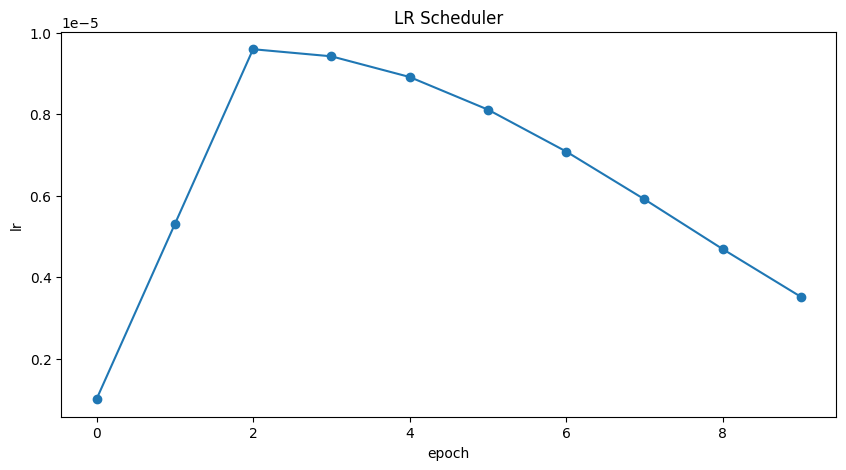

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# model checkpointing

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f'best_model.weights.h5',
                                          monitor='val_log_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')  # Get Model checkpoint callback

In [ ]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

# Modeling

In [ ]:
inputs = {
    "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
}
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
    CFG.preset,
)

# Compute embeddings for first response: (P + R_A) using backbone
response_a = {k: v[:, 0, :] for k, v in inputs.items()}
embed_a = backbone(response_a)

# Compute embeddings for second response: (P + R_B), using the same backbone
response_b = {k: v[:, 1, :] for k, v in inputs.items()}
embed_b = backbone(response_b)

embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])
embeds = keras.layers.GlobalAveragePooling1D()(embeds)
outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[
        log_loss,
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, None)      │          0 │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, None, 384) │ 70,682,112 │ get_item_1[0][0], │
│ (DebertaV3Backbone) │                   │            │ get_item[0][0],   │
│                     │                   │            │ get_item_3[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 768) │          0 │ deberta_v3_backb… │
│ (Concatenate)       │                   │            │ deberta_v3_backb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │      2,307 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,684,419 (269.64 MB)

 Trainable params: 70,684,419 (269.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2468s 835ms/step - accuracy: 0.3886 - log_loss: 1.1244 - loss: 1.1253 - val_accuracy: 0.4410 - val_log_loss: 1.0654 - val_loss: 1.0675 - learning_rate: 1.0000e-06
Epoch 2/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2315s 784ms/step - accuracy: 0.4407 - log_loss: 1.0617 - loss: 1.0638 - val_accuracy: 0.4659 - val_log_loss: 1.0370 - val_loss: 1.0395 - learning_rate: 5.3000e-06
Epoch 3/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2233s 777ms/step - accuracy: 0.4640 - log_loss: 1.0394 - loss: 1.0423 - val_accuracy: 0.4706 - val_log_loss: 1.0308 - val_loss: 1.0338 - learning_rate: 9.6000e-06


# Inferencing

In [38]:
model.load_weights('/content/drive/MyDrive/ML Projects/LLM response Classification Finetuning/best_model.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 406 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 402 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [53]:
first_record = test_df.iloc[1]
input_text = first_record["options"]
print(input_text)
input_encodings = preprocessor(input_text)
input_batch = {key: tf.expand_dims(val, axis=0) for key, val in input_encodings.items()}
predictions = model.predict(input_batch)
predicted_class_idx = tf.argmax(predictions, axis=-1).numpy()[0]
# Map to class name
predicted_label = CFG.label2name[predicted_class_idx]

# Print the result
print(f"Predicted class index: {predicted_class_idx}")
print(f"Predicted label: {predicted_label}")

["Prompt: You are a mediator in a heated political debate between two opposing parties. Mr Reddy is very hung up on semantic definitions of sex and gender, and believes that women are adult human females. Meanwhile Ms Blue is extremely fluid with definitions and does not care about truth. He (Ms blue uses he\\/him pronouns) insists that anybody can be any gender, gametes don't mean anything, and that men can get pregnant. You, Mr Goddy are tasked with helping them both find a middle ground.\n\nResponse: Thank you for sharing the details of the situation. As a mediator, I understand the importance of finding a middle ground that both parties can agree upon.\n\nIt is important to recognize that language and definitions can be complex and can vary depending on cultural and societal norms. At the same time, it is also important to acknowledge the biological differences between males and females.\n\nOne possible approach to finding a middle ground could be to focus on respecting individuals